# 2021 Dev-Matching 머신러닝 개발자

해당 문제는 대표적인 Image Classification 문제로, label은 총 7개, 이미지는 학습 데이터셋 1698장, 테스트 데이터셋 350장이 있습니다. 

해당 문제를 접근하기 위해 아래와 같은 아이디어를 생각해보았습니다. 

- (227, 227, 3) 크기의 데이터를 normalization
- imagenet으로 Pre-trained 된 base_model 가져오기
- bae_model에 CNN을 덧붙여 우리의 학습 데이터에서도 잘 예측하는 모델 확인하기



# Step 1. 필요한 모듈 불러오기

In [2]:
import tensorflow as tf
import os
import glob
from PIL import Image
import numpy as np

# Step 2. 데이터 가져오기 + 데이터 전처리하기

In [5]:
file_path = os.path.dirname(os.path.abspath('__file__'))
file_path = os.path.join(file_path, 'train')

In [20]:
target_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

def load_data(img_path):
    number_of_data = 1698
    img_size = 227
    color = 3
    
    # 이미지 데이터와 라벨 데이터를 담을 공간
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype = np.int32)
    
    idx = 0
    for label, target in enumerate(target_names):
        pth = os.path.join(file_path, target)
        for file in glob.glob(pth + '/*.jpg'):
            img = np.array(Image.open(file), dtype=np.int32)
            imgs[idx, :, :, :] = img
            labels[idx] = label
            idx += 1
    
    print("학습 데이터 x_tarin의 갯수는 ", idx)
    return imgs, labels

In [32]:
x_train, y_train = load_data(file_path)

학습 데이터 x_tarin의 갯수는  1698


In [33]:
x_train_norm = x_train / 255.0

# Step 3. Train Data를 Train set, Validation set으로 나누기

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    x_train_norm, y_train,
    test_size=0.2,
    random_state=2020
)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(1358, 227, 227, 3) (340, 227, 227, 3)
(1358,) (340,)


# Step 4. 모델 설계하기

- base model : imagenet으로 pretrained 된 MobileNet

In [58]:
import tensorflow as tf
from tensorflow import keras

In [69]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(227, 227, 3),
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False

In [87]:
model3 = keras.models.Sequential([
    base_model,
    keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(len(target_names), activation='softmax')
])

In [95]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          184336    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 231       
Total params: 2,450,775
Trainable params: 192,791
Non-trainable params: 2,257,984
______________________________________

# Step 5. 모델 학습하기

In [88]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
model3.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=30)

Epoch 1/30
43/43 [==============================] - 37s 787ms/step - loss: 1.4373 - accuracy: 0.4698 - val_loss: 0.8864 - val_accuracy: 0.7147
Epoch 2/30
43/43 [==============================] - 31s 731ms/step - loss: 0.4325 - accuracy: 0.8675 - val_loss: 0.7340 - val_accuracy: 0.7706
Epoch 3/30
43/43 [==============================] - 31s 733ms/step - loss: 0.1339 - accuracy: 0.9669 - val_loss: 0.7258 - val_accuracy: 0.7912
Epoch 4/30
43/43 [==============================] - 32s 748ms/step - loss: 0.0564 - accuracy: 0.9926 - val_loss: 0.6072 - val_accuracy: 0.8235
Epoch 5/30
43/43 [==============================] - 33s 779ms/step - loss: 0.0183 - accuracy: 0.9993 - val_loss: 0.6123 - val_accuracy: 0.8118
Epoch 6/30
43/43 [==============================] - 32s 754ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.5946 - val_accuracy: 0.8294
Epoch 7/30
43/43 [==============================] - 32s 758ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.6264 - val_accuracy: 0.8294

# Step 7. 테스트 데이터 불러와 모델에 적용하기

In [41]:
def load_test_data(img_path):
    number_of_data = 350
    img_size = 227
    color = 3
    
    # 이미지 데이터 담을 공간
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    
    idx = 0
    for file in glob.glob(img_path + '/0/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx:, :, :, :] = img
        idx += 1
    
    print("테스트 데이터 x_test의 갯수는 ", idx)
    return imgs

In [42]:
test_dir = os.path.join(file_path, 'test')
X_test = load_test_data(test_dir)
X_test_norm = X_test/255.0
print(X_test_norm.shape)

테스트 데이터 x_test의 갯수는  350
(350, 227, 227, 3)


In [89]:
y_pred3 = model3.predict(X_test_norm)
print(y_pred3.shape)
predictions3 = np.argmax(y_pred3, axis=1)

(350, 7)


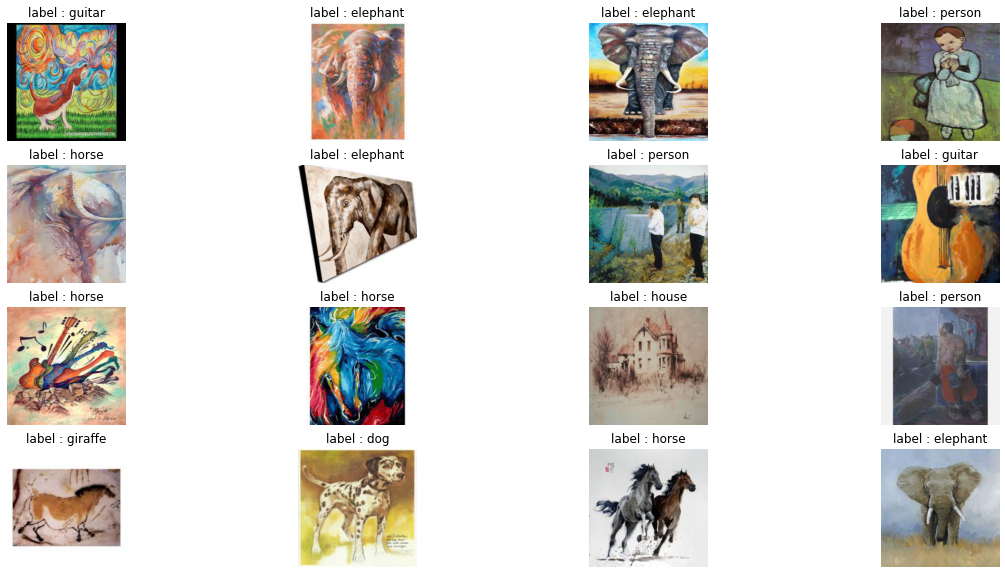

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for idx, (image, prediction) in enumerate(zip(X_test, predictions3)):
    if idx == 16:
        break
    plt.subplot(4, 4, idx+1)
    plt.imshow(image)
    plt.title("label : {}".format(target_names[prediction]))
    plt.axis('off')
plt.show()

# Step 8. submission 파일 만들기

In [40]:
import pandas as pd

file_path = os.path.dirname(os.path.abspath('__file__'))
test_path = os.path.join(file_path, 'test_answer_sample_.csv')
test = pd.read_csv(test_path)
test.head()

,Unnamed: 0,answer value
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [90]:
test['answer value'] = predictions3
test.to_csv('./submission6.csv')

# Conclusion 및 아쉬운 점

prediction을 눈으로 확인해보았을 때 나쁘지 않은 성능을 보이는 것 같았으나, 실제 리더 보드의 성적은 별로 좋지 않았습니다. 더 모델의 품질을 높이기 위해 해보았으면 좋았을 시도들은 아래와 같습니다.

- data augmentation : 색 반전, 좌우반전 등을 통해 데이터 갯수 늘리기
- 다양한 모델을 설계하고 이를 ensemble
- fine tuning : 그리드서치를 이용해 최적의 파라미터 찾기